In [1]:
#https://www.kaggle.com/code/raisularefin/nlp-multi-task-learning-with-transformers/edit

## This notebook demonstrates the multitask learning process with single encoder and with shared encoder transformers. It shows the ability of single vs shared encoder multihead attention based tasks.
### Three tasks to learn:
**>    Task # 1- Multiple-choice question/answering**

**>    Task # 2- Two-sentence similarity**

**>    Task # 3-Two-sentence entailment predicts**

### 1- Additional prediction heads to the BERT model:
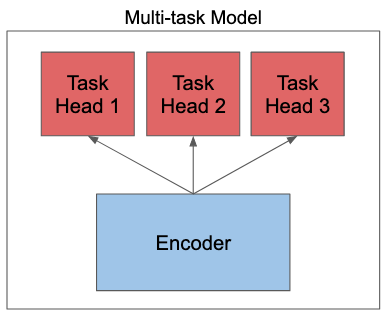



### 2- BERT-based model shared across multiple tasks being learned:
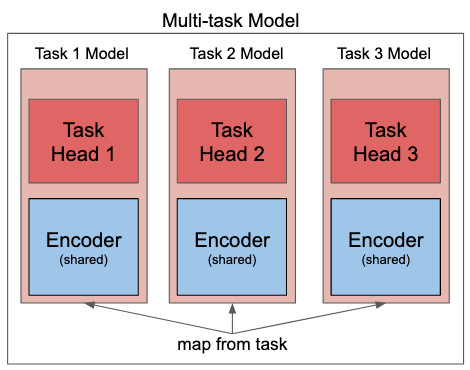

In [2]:
#We will be using packages: transformers, torch, nlp, datasets
# !pip install accelerate==0.3.0 transformers==4.10.3 nlp==0.4.0 datasets==1.9.0

## Tasks to learn: 
### 1- Multiple-choice question/answering prediction: "CommonsenseQA" dataset [link]((https://huggingface.co/datasets/commonsense_qa)).  
### An example:

> {

>     "answerKey": "B",

>     "choices": {

>         "label": ["A", "B", "C", "D", "E"],

>         "text": ["mildred's coffee shop", "mexico", "diner", "kitchen", "canteen"]

>     },

>     "question": "In what Spanish speaking North American country can you get a great cup of coffee?"
> }
### 2- Two-sentence entailment predicts whether the premise entails the hypothesis: "mnli" dataset [link](https://huggingface.co/datasets/glue).
### An example:

> {
> 
> 'premise': 'One of our number will carry out your instructions minutely.', 
> 
> 'hypothesis': 'A member of my team will execute your orders with immense precision.',
> 
> 'label': 0, 
> 
> 'idx': 2
> 
> }

### 3- Two-sentence similarity: stsb_multi_mt dataset [link](https://huggingface.co/datasets/stsb_multi_mt)
> {
> 
>     "sentence1": "A man is playing a large flute.",
>     
>     "sentence2": "A man is playing a flute.",
>     
>     "similarity_score": 3.8
> 
> }

In [3]:
import json
import pandas as pd
import numpy as np
import transformers
import datasets
from datasets import load_dataset, dataset_dict
import nlp
import dataclasses
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
#torch 
import torch
import torch.nn  as nn
from torch.utils.data.dataloader import DataLoader
# from transformers.training_args import is_tpu_available
# from transformers.trainer import get_tpu_sampler

from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict
# logging.basicConfig(level=logging.info)

In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [5]:
#Loading datasets 
dataset_dict = {
    "mnli": datasets.load_dataset('glue', 'mnli'),
    "commonsense_qa": datasets.load_dataset('commonsense_qa',name='commonsense_qa'),
    "stsb_multi_mt": datasets.load_dataset("stsb_multi_mt",name="en")
}

Reusing dataset glue (/home/nahid/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Using custom data configuration commonsense_qa
Reusing dataset commonsense_qa (/home/nahid/.cache/huggingface/datasets/commonsense_qa/commonsense_qa/0.1.0/1ca2d7b680c5bd93c0dc85f9cb65c0c8817e759ff82e405b28de54e83efa80f7)
Reusing dataset stsb_multi_mt (/home/nahid/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/bc6de0eaa8d97c28a4c22a07e851b05879ae62c60b0b69dd6b331339e8020f07)


In [6]:
for key, value in  dataset_dict.items():
    print("task:", key)
    print(dataset_dict[key]['train'][2])
    print("\n")

task: mnli
{'premise': 'One of our number will carry out your instructions minutely.', 'hypothesis': 'A member of my team will execute your orders with immense precision.', 'label': 0, 'idx': 2}


task: commonsense_qa
{'answerKey': 'A', 'question': 'To locate a choker not located in a jewelry box or boutique where would you go?', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['jewelry store', 'neck', 'jewlery box', 'jewelry box', 'boutique']}}


task: stsb_multi_mt
{'sentence1': 'A man is spreading shreded cheese on a pizza.', 'sentence2': 'A man is spreading shredded cheese on an uncooked pizza.', 'similarity_score': 3.799999952316284}




**Some visualization**

<Figure size 640x480 with 0 Axes>

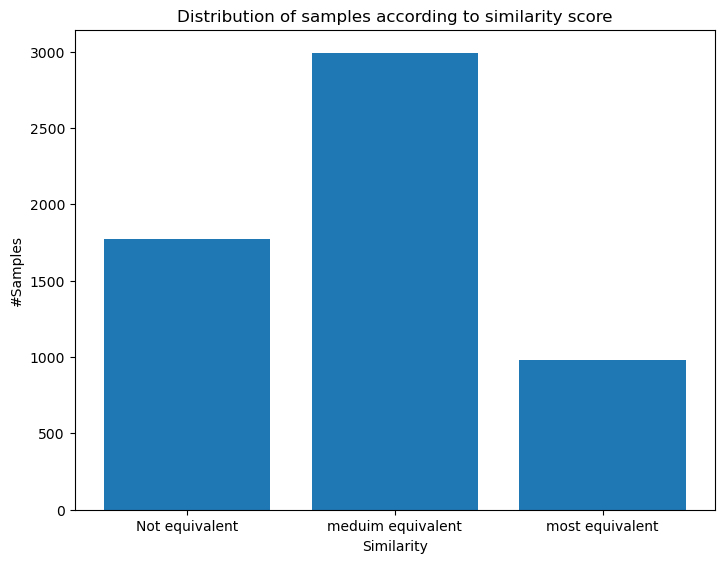

In [7]:
l=dataset_dict['stsb_multi_mt']['train']['similarity_score']
fig=plt.figure()
fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Not equivalent', 'meduim equivalent', 'most equivalent']
students = [len([x for x in l if int(x)<2]),len([x for x in l if int(x)>2]),len([x for x in l if int(x)==2])]
ax.bar(langs,students)
plt.xlabel("Similarity")
plt.ylabel("#Samples")
plt.title("Distribution of samples according to similarity score")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


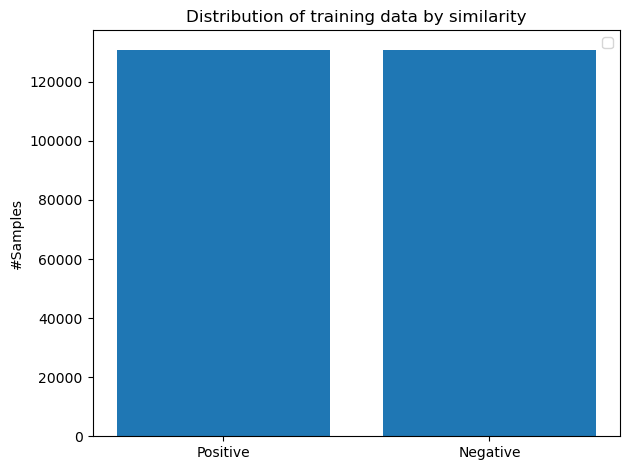

In [8]:
l=dataset_dict['mnli']['train']['label']
l1=dataset_dict['mnli']['train']['label']
labels = ['Positive', 'Negative']
data = [len([x for x in l if int(x)==0]),  len([x for x in l if int(x)==1]) ]

#test=[len([x for x in l if int(x)==1]),len([x for x in l1 if int(x)==1])]
           
x = np.arange(len(labels)) 
width = 0.35
fig, ax = plt.subplots()
ax.bar( labels, data)
#rects2 = ax.bar( x + width/2, test, width, label='Positive')

ax.set_ylabel('#Samples')
ax.set_title('Distribution of training data by similarity')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

# Build a Multi-task Model

In [9]:
class MultitaskModel(transformers.PreTrainedModel):

    def __init__(self, encoder, taskmodels_dict):
        
        """
        Setting MultitaskModel up as a PretrainedModel allows us
        to take better advantage of Trainer features
        """
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)
    
    @classmethod
    def create_model(cls, model_name, model_type_dict, model_config_dict):
        """
        This creates a MultitaskModel using the model class and config objects
        from single-task models. 

        We do this by creating each single-task model, and having them share
        the same encoder transformer.
        """
        shared_encoder = None
        task_models_dict = {}
        for task, model_type in model_type_dict.items():
            print(task)
            print(model_type)
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task],
            )
            if shared_encoder is None:
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            task_models_dict[task] = model
        return cls(encoder=shared_encoder, taskmodels_dict=task_models_dict)
    
        
    @classmethod              
    def get_encoder_attr_name(cls, model):
        
        
        """
        Each encoder has its attributes according to model architecture: BERT, Roberta,Alberta 
        This function gets attribute of the encoder.
        """
        model_class_name = model.__class__.__name__
        if model_class_name.startswith('Bert'):
            return 'bert'
        if model_class_name.startswith('Roberta'):
            return 'roberta'
        if model_class_name.startswith('Albert'):
            return 'albert'
        if model_class_name.startswith():
            return 
            
        else:
                raise KeyError(f"Add support for new model {model_class_name}")
                
        
    def forward(self, task, **kwargs):
        return self.taskmodels_dict[task](**kwargs)

In [21]:
model_name='roberta-base'
multitask_model=MultitaskModel.create_model(model_name=model_name, 
         model_type_dict={
                 "mnli" : transformers.AutoModelForSequenceClassification,
                 "commonsense_qa": transformers.AutoModelForMultipleChoice,
                 "stsb_multi_mt"          : transformers.AutoModelForSequenceClassification
         },
         model_config_dict={
                 "mnli" : transformers.AutoConfig.from_pretrained(model_name,num_labels=1),
                 "commonsense_qa": transformers.AutoConfig.from_pretrained(model_name),
                 "stsb_multi_mt"          : transformers.AutoConfig.from_pretrained(model_name,num_labels=1)
             
         }                                   
            )

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/nahid/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 1,
  "use_cache": true,

mnli
<class 'transformers.models.auto.modeling_auto.AutoModelForSequenceClassification'>


loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /home/nahid/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identica

commonsense_qa
<class 'transformers.models.auto.modeling_auto.AutoModelForMultipleChoice'>


loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /home/nahid/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultipleChoice: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassifi

stsb_multi_mt
<class 'transformers.models.auto.modeling_auto.AutoModelForSequenceClassification'>


loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /home/nahid/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identica

### check if all three models to be trained share the same encoder 

In [22]:
if model_name.startswith('roberta-base'):
    print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict['mnli'].roberta.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict['commonsense_qa'].roberta.embeddings.word_embeddings.weight.data_ptr())
    print(multitask_model.taskmodels_dict['stsb_multi_mt'].roberta.embeddings.word_embeddings.weight.data_ptr())
else:
    print("Ckeck the model name")

2422053248
2422053248
2422053248
2422053248


In [24]:
from transformers import BertTokenizer, BertForPreTraining, AdamW
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom dataset class for both tasks
class MultiTaskDataset(Dataset):
    def __init__(self, text_list, label_list, task):
        self.text_list = text_list
        self.label_list = label_list
        self.task = task
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    def __len__(self):
        return len(self.text_list)
    
    def __getitem__(self, idx):
        text = self.text_list[idx]
        label = self.label_list[idx]
        encoded_input = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()
        
        if self.task == 'classification':
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': torch.tensor(label)
            }
        elif self.task == 'mlm':
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'masked_labels': encoded_input['input_ids'].squeeze()
            }
        else:
            raise ValueError('Invalid task provided.')

# Example data
texts = ['This is the first sentence.', 'Another example sentence.', 'And a third sentence.']
classification_labels = [0, 1, 0]
mlm_labels = texts

# Create the dataset for each task
classification_dataset = MultiTaskDataset(texts, classification_labels, task='classification')
mlm_dataset = MultiTaskDataset(texts, mlm_labels, task='mlm')

# Create data loaders
batch_size = 2
classification_dataloader = DataLoader(classification_dataset, batch_size=batch_size, shuffle=True)
mlm_dataloader = DataLoader(mlm_dataset, batch_size=batch_size, shuffle=True)

# Load the pre-trained BERT model
model = BertForPreTraining.from_pretrained('bert-base-uncased')

# Set the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/nahid/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/nahid/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /home/nahid/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for batch_classification, batch_mlm in zip(classification_dataloader, mlm_dataloader):
        optimizer.zero_grad()
        
        # Classification task forward pass
        classification_inputs = {
            'input_ids': batch_classification['input_ids'],
            'attention_mask': batch_classification['attention_mask'],
            'labels': batch_classification['labels']
        }
        outputs = model(**classification_inputs)
        classification_loss = outputs.loss
        print
        
        # MLM task forward pass
        mlm_inputs = {
            'input_ids': batch_mlm['input_ids'],
            'attention_mask': batch_mlm['attention_mask'],
            'masked_lm_labels': batch_mlm['masked_labels']
        }
        mlm_outputs = model(**mlm_inputs)
        mlm_loss = mlm_outputs.loss
        
        # Combined loss
        total_loss = classification_loss + mlm_loss
        
        # Backpropagation and optimization
        total_loss.backward()
        optimizer.step()

## Data preprocesing:


#### 1- We should transform the dictionary of dataset to NLP model inputs: Get the tokenizer corresponding to our model.

#### 2- Preparing the inputs for a model: **mnli** and **sst2** datasets are two-sentence inputs data we should concatenate the inputs in one vector. While **commonsense_qa** has multi-choice inputs with question. One   

In [23]:
tokenizer=transformers.AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/nahid/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.3",
  "type_vocab_size": 1,
  "us

In [13]:
max_length=64
def convert_to_mnli_inputs(example_batch):
    
    inputs=list(zip(example_batch['premise'],example_batch['hypothesis']))
    features=tokenizer.batch_encode_plus(inputs, max_length=max_length, 
                                         pad_to_max_length=True,truncation=True)
    features['labels']=example_batch['label']
    return features

def convert_to_stsb_multi_mt_inputs(example_batch):
    
    inputs=list(zip(example_batch['sentence1'],example_batch['sentence2']))
    features=tokenizer.batch_encode_plus(inputs, max_length=max_length, 
                                         pad_to_max_length=True,truncation=True)
    features['labels']=example_batch['similarity_score']
    return features

def convert_to_commonsense_qa_inputs(example_batch):
    
    number_examples=len(example_batch['question'])
    number_choices=len(example_batch['choices'][0]['text'])
    features={}
    for example in range(number_examples):
        choices=tokenizer.batch_encode_plus(
            list(zip([example_batch['question'][example]]*number_choices,
                        example_batch['choices'][example]['text'])),
            max_length=max_length, pad_to_max_length=True ,truncation=True
                    )
        for k,v in choices.items():
            if k not in  features:
                features[k]=[]
            features[k].append(v)
    labels2id={char: x for x, char in enumerate('ABCDE')}
    if example_batch['answerKey'][0]:
        features['labels']= [labels2id[ans] for ans in example_batch['answerKey']]
    else:
        features['labels']=[0]*number_examples
    return features

#Construct the featurized input data
featurized_funct_dict={
                 "mnli"          : convert_to_mnli_inputs,
                 "commonsense_qa": convert_to_commonsense_qa_inputs,
                 "stsb_multi_mt" : convert_to_stsb_multi_mt_inputs
}

column_dict={
                 "mnli"          : ['input_ids', 'attention_mask','labels'],
                 "commonsense_qa": ['input_ids', 'attention_mask','labels'],
                 "stsb_multi_mt" : ['input_ids', 'attention_mask','labels']
}
#Featurizing datasets
features_dict={}
for  task, dataset in dataset_dict.items():
    print("--------------task---------:",task)
    features_dict[task]={}
    for phase, phase_dataset in dataset.items():
       
        features_dict[task][phase]=phase_dataset.map(featurized_funct_dict[task],
                                                     batched=True, 
                                                     load_from_cache_file=False)
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))
        features_dict[task][phase].set_format(
            type='torch',
            columns=column_dict[task]
        )
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))

Parameter 'function'=<function convert_to_mnli_inputs at 0x7ff856ac4430> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


--------------task---------: mnli


  0%|          | 0/393 [00:00<?, ?ba/s]

/home/nahid/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


mnli train 392702 392702
mnli train 392702 392702


  0%|          | 0/10 [00:00<?, ?ba/s]

mnli validation_matched 9815 9815
mnli validation_matched 9815 9815


  0%|          | 0/10 [00:00<?, ?ba/s]

mnli validation_mismatched 9832 9832
mnli validation_mismatched 9832 9832


  0%|          | 0/10 [00:00<?, ?ba/s]

mnli test_matched 9796 9796
mnli test_matched 9796 9796


  0%|          | 0/10 [00:00<?, ?ba/s]

mnli test_mismatched 9847 9847
mnli test_mismatched 9847 9847
--------------task---------: commonsense_qa


  0%|          | 0/10 [00:00<?, ?ba/s]

commonsense_qa train 9741 9741
commonsense_qa train 9741 9741


  0%|          | 0/2 [00:00<?, ?ba/s]

commonsense_qa validation 1221 1221
commonsense_qa validation 1221 1221


  0%|          | 0/2 [00:00<?, ?ba/s]

commonsense_qa test 1140 1140
commonsense_qa test 1140 1140
--------------task---------: stsb_multi_mt


  0%|          | 0/6 [00:00<?, ?ba/s]

stsb_multi_mt train 5749 5749
stsb_multi_mt train 5749 5749


  0%|          | 0/2 [00:00<?, ?ba/s]

stsb_multi_mt test 1379 1379
stsb_multi_mt test 1379 1379


  0%|          | 0/2 [00:00<?, ?ba/s]

stsb_multi_mt dev 1500 1500
stsb_multi_mt dev 1500 1500


**We have created our multi-task model by fusing several single-task Transformer models.**

**We have featurized NLP datasets to construct inputs for each of our tasks.**

> **Now, its is time to set updata loader and set up the Trainer then , train the single encoder model with three tasks included. We should feed batches into the multitask model by sampling from the featured dataset** 

In [14]:
#Class to sample bacth from the featurized datasets, The Datac is extended to work with batches
#Data collators are objects that will form a batch by using a list of dataset elements as input

# from transformers.data.data_collator import  InputDataClass  as IDC

# from transformers.data.data_collator import  DataCollator

from transformers.data import data_collator as DC
# from DataCollator import DataCollator



class NLPDataCollator(DC.DefaultDataCollator):
    def collate_batch(self, features:List[Union[DC.InputDataClass,Dict]]) -> Dict[str,torch.Tensor]:
        first=features[0]
        if isinstance(first,dict):
            
            #featurized dataset are in the form of list of dictionaries
            #Adapt the DataCollator to have a list of dictionary
            if "labels" in first and first["labels"] is not None:
                if first["labels"].dtype == torch.int64:
                    labels = torch.tensor(
                        [f["labels"] for f in features], dtype=torch.float
                    )
                else:
                    labels = torch.tensor(
                        [f["labels"] for f in features], dtype=torch.float
                    )
                batch = {"labels": labels}
            for k, v in first.items():
                if k != "labels" and v is not None and not isinstance(v, str):
                    batch[k] = torch.stack([f[k] for f in features])
            return batch
        else:
            # otherwise, revert to using the default collate_batch
            return DefaultDataCollator().collate_batch(features)

                    
class StrIgnoreDevice(str):
    """
    This is a hack. The Trainer is going call .to(device) on every input
    value, but we need to pass in an additional `task_name` string.
    This prevents it from throwing an error
    """
    def to(self, device):
        return self        

In [15]:
#Class to load data with its task name. Decorator for changing Dataloader function to use a task name
class DataLoaderTaskname:
    def __init__(self, task, data_loader):
        self.task=task
        self.data_loader=data_loader
        self.batch_size=data_loader.batch_size
        self.dataset=data_loader.dataset
        
    def __len__(self):
        return len(self.data_loader)
        
    def __iter__(self):
        for batch in self.data_loader:
            batch["task"]=StrIgnoreDevice(self.task)
            yield batch

In [16]:
#Class to combine several data loaders into a single "data loader" 
class MultitaskDataLoader:
    
    def __init__(self, dataloader_dict):
        self.dataloader_dict =dataloader_dict
        self.num_batches_dict= {task:len(dataloader) for task, dataloader in self.dataloader_dict.items()}
        self.task_lst        =list(self.dataloader_dict)
        self.dataset = [None] * sum(len(dataloader.dataset) for dataloader in self.dataloader_dict.values())
    def __len__(self):
        return sum(self.num_batches_dict.values())
    
    def __iter__(self):
        """
        For each batch, sample a task, and get a batch from the respective task Dataloader.

        We use size-proportional sampling, but you could easily modify this
        to sample from some-other distribution.
        """
        task_choice_list = []
        for i, task in enumerate(self.task_lst):
            task_choice_list += [i] * self.num_batches_dict[task]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task: iter(dataloader) 
            for task, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task = self.task_lst[task_choice]
            yield next(dataloader_iter_dict[task])   

In [17]:
#class to set up the trainer 
class MultitaskTrainer(transformers.Trainer):
    
    def single_task_dataloader(self,task,train_dataset):
        """
        returns the single task data loader of a given task 
        """
        if self.train_dataset is None:
            raise ValueError("Trainer needs a dataset...:(")
#         if is_tpu_available():
#             train_sampler=get_tpu_sampler(train_dataset)
#         else:
        train_sampler=(RandomSampler(train_dataset)  if self.args.local_rank== -1 
                                                            else DistributedSampler(train_dataset))
    
        data_loader=DataLoaderTaskname(task=task,data_loader=DataLoader(train_dataset,
                                                                       batch_size=self.args.train_batch_size,
                                                                       sampler=train_sampler,
                                                                       collate_fn=self.data_collator.collate_batch
                                                                      ))   
#         if is_tpu_available():
#             data_loader=pl.ParallelLoader(
#                 data_loader, [self.args.device]
#             ).per_device_loader(self.args.device)
        return data_loader
    
    
    def get_train_dataloader(self):
        """
        Returns a MultitaskDataLoader, which is not actually a Dataloader
        but an iterable that returns a generator that samples from each 
        task Dataloader
        """
        return MultitaskDataLoader({
            task: self.single_task_dataloader(task, task_dataset)
            for task, task_dataset in self.train_dataset.items()
        })

# Training Multitask model

In [18]:
train_dataset = {
    task: dataset["train"] 
    for task, dataset in features_dict.items()
}
trainer = MultitaskTrainer(
    model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="./models/multitask_model",
        overwrite_output_dir=True,
        learning_rate=1e-5,
        do_train=True,
        num_train_epochs=2,
        # Adjust batch size if this doesn't fit on the Colab GPU
        per_device_train_batch_size=8,  
        save_steps=3000,
    ),
    data_collator=NLPDataCollator(),
    train_dataset=train_dataset,
)
trainer.train()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
***** Running training *****
  Num examples = 408192
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 102050


Step,Training Loss


TypeError: expected Tensor as element 0 in argument 0, but got list

# Prediction 

In [ ]:
preds_dict = {}
for task in ["mnli", "commonsense_qa", "stsb_multi_mt"]:
    eval_dataloader = DataLoaderTaskname(
        task,
        trainer.get_eval_dataloader(eval_dataset=features_dict[task]["validation"])
    )
    print(eval_dataloader.data_loader.collate_fn)
    preds_dict[task] = trainer._prediction_loop(
        eval_dataloader, 
        description=f"Validation: {task}",
    )

In [ ]:
def save_model(model_name, multitask_model):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    for task_name in ["spaadia_squad_pairs", "quora_keyword_pairs"]:
        multitask_model.taskmodels_dict[task_name].config.to_json_file(
            f"./{task_name}_model/config.json"
        )
        torch.save(
            multitask_model.taskmodels_dict[task_name].state_dict(),
            f"./{task_name}_model/pytorch_model.bin",
        )
        tokenizer.save_pretrained(f"./{task_name}_model/")

#### More detailed codes are [here](https://github.com/shahrukhx01/multitask-learning-transformers) 